In [89]:
import torch
import wandb
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = "mps"

In [3]:
# TODO: implement decoder as a CNN (transposed convolutions starting with one pixel with channel dim 20)

In [121]:
class ResidualBlock(nn.Module):
    def __init__(self, c_dim):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(c_dim, c_dim, kernel_size=3, stride=1, padding="same", bias=False)
        self.bn1 = nn.BatchNorm2d(c_dim)
        self.conv2 = nn.Conv2d(c_dim, c_dim, kernel_size=3, stride=1, padding="same", bias=False)
        self.bn2 = nn.BatchNorm2d(c_dim)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.bn2(self.conv2(out))
        out += residual # residual connection
        # downsample
        out = F.max_pool2d(out, 2)
        out = F.relu(out)
        return out


class VAE_encoder(nn.Module):
    def __init__(self):
        super(VAE_encoder, self).__init__()
        # cnn based encoder
        # each residual block has reduces the image size by 2x (we start with 28x28)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=1, padding="same", bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.res1 = ResidualBlock(64) # 64x14x14
        self.res2 = ResidualBlock(64) # 64x7x7
        self.res3 = ResidualBlock(64) # 64x3x3
        self.conv2 = nn.Conv2d(64, 40, kernel_size=3, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(40)


    def forward(self, x) -> tuple[torch.Tensor, torch.Tensor]:
        # cnn based encoder
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x.view(-1, 40)
        mu = x[:, :20]
        logvar = x[:, 20:]
        return mu, logvar

    def sample(self, mu, logvar) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
# mlp based decoder
class VAE_decoder(nn.Module):
    def __init__(self):
        super(VAE_decoder, self).__init__()
        self.fc1 = nn.Linear(20, 128)
        self.norm1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 512)
        self.norm2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 784)
        self.norm3 = nn.BatchNorm1d(784)

    def forward(self, z):
        x = self.fc1(z)
        x = F.relu(self.norm1(x))
        x = F.relu(self.norm2(self.fc2(x)))
        x = self.norm3(self.fc3(x))
        return x


In [122]:
def kl_divergence(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [123]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = VAE_encoder()
        self.decoder = VAE_decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        kl_div = kl_divergence(mu, logvar)
        z = self.encoder.sample(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, kl_div

In [133]:
# load images
MEAN = 0.1307
STD = 0.3081
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD), # mean and std of MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [127]:
vae = VAE().to(device)
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-3)

In [ ]:
# set up wandb logging
wandb.init(
    project="vae_experiments",
    config={
        "epochs": 20,
        "batch_size": 64,
        "learning_rate": 1e-3,
        "optimizer": "AdamW",
        "total_loss": "MSE + KL",
        "architecture": "CNN based",
        "activation": "ReLU",
        "latent_dim": 20,
        "dataset": "MNIST"
    }
)

In [148]:
# training loop
vae.train()
sampled_z = torch.randn(1, 20).to(device)
for epoch in range(20):
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.to(device)
        # image = image.view(image.size(0), -1)
        optimizer.zero_grad()
        x_hat, kl_div = vae(image)
        reconstruction_loss = F.mse_loss(x_hat, image.view(image.size(0), -1), reduction="sum")
        loss = reconstruction_loss + kl_div
        wandb.log({"total_loss": loss.item()})
        wandb.log({"kl_div": kl_div.item()})
        wandb.log({"reconstruction_loss": reconstruction_loss.item()})
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            with torch.no_grad():
                print(f"Epoch: {epoch} | Batch: {batch_idx} | Loss: {loss.item()}")
                
    with torch.no_grad():
        # sample random image from gaussian
        vae.eval()
        sampled_x = vae.decoder(sampled_z)
        # denomralize image
        sampled_x = (sampled_x * STD + MEAN).clamp(0, 1)
        x_hat = (x_hat * STD + MEAN).clamp(0, 1)
        image = (image * STD + MEAN).clamp(0, 1)
        wandb.log({
            "images": [
                wandb.Image(image[0].view(28, 28)),
                wandb.Image(x_hat[0].view(28, 28)),
                wandb.Image(sampled_x[0].view(28, 28))
            ]
        })
        vae.train()

Epoch: 0 | Batch: 0 | Loss: 10763.93359375
Epoch: 0 | Batch: 100 | Loss: 10601.29296875
Epoch: 0 | Batch: 200 | Loss: 10344.1630859375
Epoch: 0 | Batch: 300 | Loss: 10648.3779296875
Epoch: 0 | Batch: 400 | Loss: 10444.7294921875
Epoch: 0 | Batch: 500 | Loss: 10875.353515625
Epoch: 0 | Batch: 600 | Loss: 10424.1689453125
Epoch: 0 | Batch: 700 | Loss: 10161.7822265625
Epoch: 0 | Batch: 800 | Loss: 10173.220703125
Epoch: 0 | Batch: 900 | Loss: 10298.615234375
Epoch: 1 | Batch: 0 | Loss: 10324.6103515625
Epoch: 1 | Batch: 100 | Loss: 10345.693359375
Epoch: 1 | Batch: 200 | Loss: 9871.2734375
Epoch: 1 | Batch: 300 | Loss: 10415.552734375
Epoch: 1 | Batch: 400 | Loss: 10322.6298828125
Epoch: 1 | Batch: 500 | Loss: 10993.4267578125
Epoch: 1 | Batch: 600 | Loss: 10083.9072265625
Epoch: 1 | Batch: 700 | Loss: 10099.1103515625
Epoch: 1 | Batch: 800 | Loss: 9948.6513671875
Epoch: 1 | Batch: 900 | Loss: 10353.50390625
Epoch: 2 | Batch: 0 | Loss: 9944.330078125
Epoch: 2 | Batch: 100 | Loss: 10107.5

wandb: Network error (ReadTimeout), entering retry loop.


Epoch: 4 | Batch: 700 | Loss: 10249.4970703125
Epoch: 4 | Batch: 800 | Loss: 9947.203125
Epoch: 4 | Batch: 900 | Loss: 9939.123046875
Epoch: 5 | Batch: 0 | Loss: 9620.568359375
Epoch: 5 | Batch: 100 | Loss: 9911.279296875
Epoch: 5 | Batch: 200 | Loss: 10369.853515625
Epoch: 5 | Batch: 300 | Loss: 10425.8828125
Epoch: 5 | Batch: 400 | Loss: 9772.8828125
Epoch: 5 | Batch: 500 | Loss: 10763.6025390625
Epoch: 5 | Batch: 600 | Loss: 9932.16015625
Epoch: 5 | Batch: 700 | Loss: 9686.47265625
Epoch: 5 | Batch: 800 | Loss: 10036.716796875
Epoch: 5 | Batch: 900 | Loss: 10375.80859375
Epoch: 6 | Batch: 0 | Loss: 9631.166015625
Epoch: 6 | Batch: 100 | Loss: 10840.23046875
Epoch: 6 | Batch: 200 | Loss: 10239.837890625
Epoch: 6 | Batch: 300 | Loss: 10049.677734375
Epoch: 6 | Batch: 400 | Loss: 10888.5615234375
Epoch: 6 | Batch: 500 | Loss: 10188.5419921875
Epoch: 6 | Batch: 600 | Loss: 10697.5908203125
Epoch: 6 | Batch: 700 | Loss: 9823.5166015625
Epoch: 6 | Batch: 800 | Loss: 10057.6083984375
Epoch

In [149]:
# testing loss over entire test set
vae.eval()
with torch.no_grad():
    test_loss = 0
    for batch_idx, (image, _) in enumerate(test_loader):
        image = image.to(device)
        # image = image.view(image.size(0), -1)
        x_hat, kl_div = vae(image)
        reconstruction_loss = F.mse_loss(x_hat, image.view(image.size(0), -1), reduction="sum")
        loss = reconstruction_loss + kl_div
        test_loss += loss.item()
    print(f"Test loss: {test_loss / len(test_loader)}")
        

Test loss: 7913.541943203872


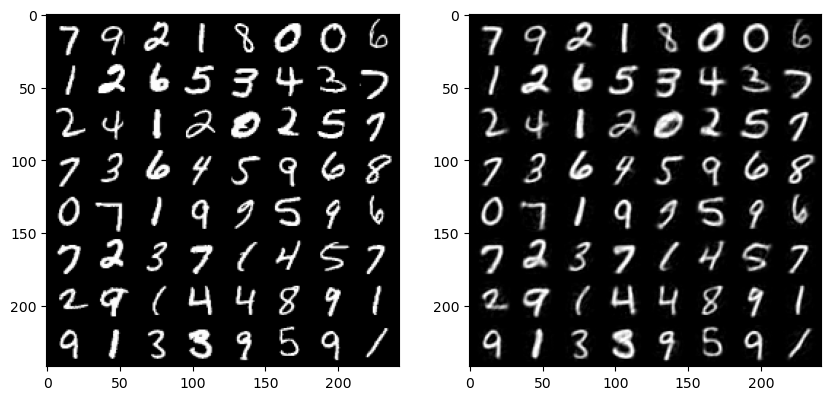

In [151]:
# plotting images vs reconstructed images
images = next(iter(test_loader))[0].to(device)

with torch.no_grad():
    vae.eval()
    x_hat, _ = vae(images)
    x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

    # denormalize images
    x_hat = x_hat * STD + MEAN
    images = images * STD + MEAN

    # plotting images
    x_hat = x_hat.view(-1, 1, 28, 28).clamp(0, 1)
    images = images.view(-1, 1, 28, 28).clamp(0, 1)

    # turn x_hat and images into grids
    x_hat = torchvision.utils.make_grid(x_hat, nrow=8).permute(1, 2, 0).cpu().numpy()
    images = torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0).cpu().numpy()

    # plot images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(images, cmap="gray")
    ax[1].imshow(x_hat, cmap="gray")
    plt.show()

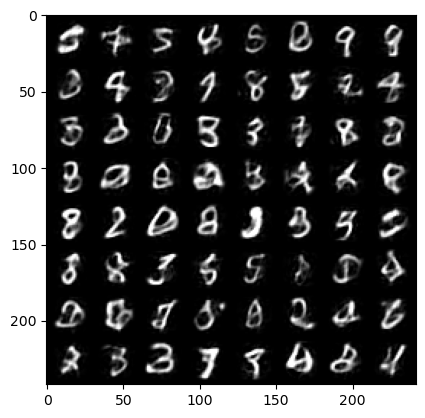

In [152]:
# sample random images from the latent space
with torch.no_grad():
    vae.eval()
    z = torch.randn(64, 20).to(device)
    x_hat = vae.decoder(z)
    x_hat = x_hat.view(-1, 1, 28, 28)

    # denormalize images
    x_hat = (x_hat * STD + MEAN).clamp(0, 1)

    # plot images
    plt.imshow(torchvision.utils.make_grid(x_hat, nrow=8).permute(1, 2, 0).cpu().numpy())

tensor(2.8215, device='mps:0') tensor(-0.4242, device='mps:0')


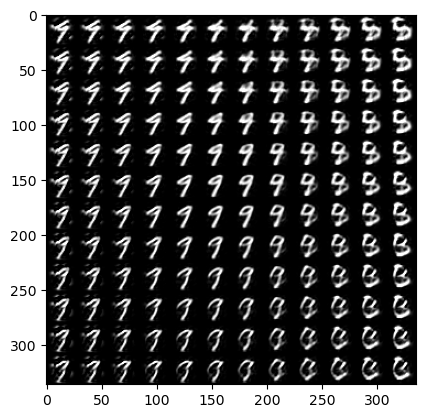

In [178]:
# tweak the first component of the latent vector
with torch.no_grad():
    width = 12
    tweak_spectrum = [[0] * width for _ in range(width)]
    vae.eval()
    shifts = torch.linspace(-6, 6, width).to(device)
    x = next(iter(test_loader))[0][0].to(device).unsqueeze(0)
    print(x.max(), x.min())
    z, _ = vae.encoder(x)
    for i in range(width):
        for j in range(width):
            tweaked_z = z.clone().squeeze()
            tweaked_z[4] = tweaked_z[4] + shifts[i]
            tweaked_z[19] = tweaked_z[19] + shifts[j]
            x_hat = vae.decoder(tweaked_z.unsqueeze(0))
            x_hat = x_hat.view(-1, 1, 28, 28)

            # denormalize images
            x_hat = (x_hat * STD + MEAN).clamp(0, 1)
            
            tweak_spectrum[i][j] = x_hat

    # represent the images as a grid
    tweak_spectrum = torch.cat([torch.cat(row, dim=3) for row in tweak_spectrum], dim=2)
    tweak_spectrum = tweak_spectrum.view(tweak_spectrum.size(0), 1, 28 * width, 28 * width)

    # plot the grid of images in matplotlib
    plt.imshow(tweak_spectrum[0].cpu().numpy().squeeze(), cmap="gray")
    plt.show()
    